In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import cv2

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense

import matplotlib.pyplot as plotter

In [59]:
train = pd.read_csv('/content/drive/MyDrive/Facultate/year2-sem2/data-vis/project/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Facultate/year2-sem2/data-vis/project/data/test.csv')
valid = pd.read_csv('/content/drive/MyDrive/Facultate/year2-sem2/data-vis/project/data/validation.csv')

In [60]:
categorical_cols = ['Address', 'Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

In [61]:
for col in categorical_cols:
  train[col] = pd.factorize(train[col])[0]
  test[col] = pd.factorize(test[col])[0]
  valid[col] = pd.factorize(valid[col])[0]

train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)
test['Date']= pd.to_datetime(test['Date'], infer_datetime_format=True)
valid['Date']= pd.to_datetime(valid['Date'], infer_datetime_format=True)

train['Date'] = train['Date'].apply(lambda x:x.toordinal())
test['Date']= test['Date'].apply(lambda x:x.toordinal())
valid['Date']= valid['Date'].apply(lambda x:x.toordinal())

<ipython-input-61-6a2c7945362c>:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)
<ipython-input-61-6a2c7945362c>:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test['Date']= pd.to_datetime(test['Date'], infer_datetime_format=True)
<ipython-input-61-6a2c7945362c>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  valid['Date']= pd.to_datetime(valid['Date'], infer_datetime_format=True)


In [62]:
X_train = np.array(train.loc[:, train.columns != 'Price']).astype('float32')
X_test = np.array(test.loc[:, test.columns != 'Price']).astype('float32')
X_valid = np.array(valid.loc[:, valid.columns != 'Price']).astype('float32')

In [63]:
y_train = np.array(train['Price']).astype('float32')
y_test = np.array(test['Price']).astype('float32')
y_valid = np.array(valid['Price']).astype('float32')

In [64]:
def normalize_inputs(training_set, test_set, validation_set):
  maxes = [train.max().max(), test.max().max(), valid.max().max()]
  ds_max = max(maxes)
  return tf.cast(training_set, tf.float32) / ds_max, tf.cast(test_set, tf.float32) / ds_max, tf.cast(validation_set, tf.float32) / ds_max

X_train, X_test, X_valid = normalize_inputs(train, test, valid)

In [65]:
def root_mean_squared_error_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

In [66]:
def build_mlp_net():
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1,  activation="linear"))

  optimizer_tehnique = tf.optimizers.Adam(learning_rate=1e-3)

  model.compile(metrics=[tf.keras.metrics.RootMeanSquaredError()], loss=root_mean_squared_error_loss, optimizer=optimizer_tehnique)

  return model

In [67]:
EPOCHS_COUNT = 500
SIZE_PER_BATCH = 256

In [68]:
model = build_mlp_net()

In [69]:
performance_audit = model.fit(x=X_train, y=y_train, batch_size=SIZE_PER_BATCH, epochs=EPOCHS_COUNT, validation_data=(X_valid, y_valid))

Epoch 1/500
86/86 [==============================] - 2s 5ms/step - loss: 1229921.1250 - root_mean_squared_error: 1232086.5000 - val_loss: 1227387.8750 - val_root_mean_squared_error: 1228760.5000
Epoch 2/500
86/86 [==============================] - 0s 4ms/step - loss: 1230317.3750 - root_mean_squared_error: 1231988.3750 - val_loss: 1227170.3750 - val_root_mean_squared_error: 1228543.2500
Epoch 3/500
86/86 [==============================] - 0s 3ms/step - loss: 1229974.8750 - root_mean_squared_error: 1231559.6250 - val_loss: 1226475.5000 - val_root_mean_squared_error: 1227849.5000
Epoch 4/500
86/86 [==============================] - 0s 3ms/step - loss: 1228639.3750 - root_mean_squared_error: 1230504.8750 - val_loss: 1225024.0000 - val_root_mean_squared_error: 1226400.0000
Epoch 5/500
86/86 [==============================] - 0s 4ms/step - loss: 1226724.2500 - root_mean_squared_error: 1228564.0000 - val_loss: 1222567.0000 - val_root_mean_squared_error: 1223946.3750
Epoch 6/500
86/86 [======

In [70]:
def plot_performance_history(results, mapping):
  for key in mapping:
    plotter.plot(results[key], label=mapping[key])
  plotter.legend()
  plotter.xlabel('Epochs count')
  plotter.show()

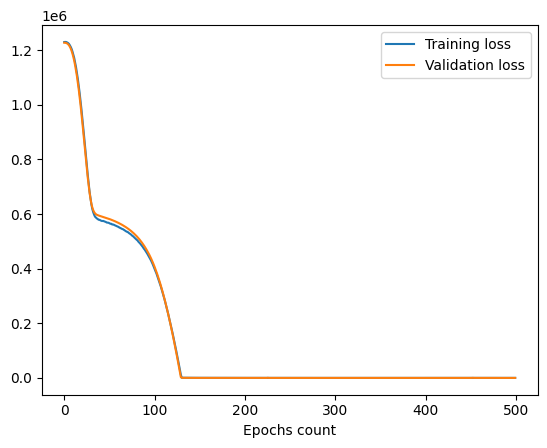

In [71]:
mapping = {
    "loss": "Training loss",
    "val_loss": "Validation loss"
}
plot_performance_history(performance_audit.history, mapping)

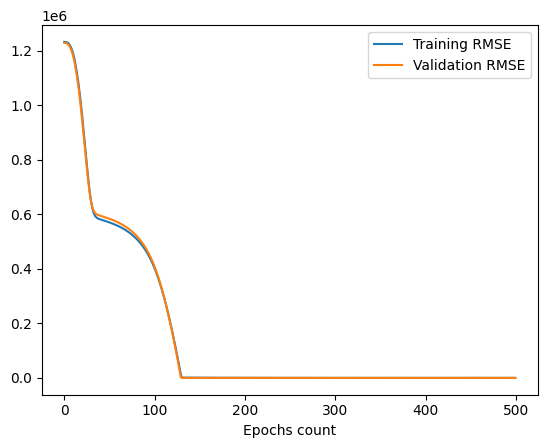

In [72]:
mapping = {
    "root_mean_squared_error": "Training RMSE",
    "val_root_mean_squared_error": "Validation RMSE"
}
plot_performance_history(performance_audit.history, mapping)

In [73]:
test_set_results = model.evaluate(X_test, y_test, batch_size=SIZE_PER_BATCH)
print(f'Test loss: {test_set_results[0]} ---- Test RMSE: {test_set_results[1]}')

11/11 [==============================] - 0s 2ms/step - loss: 47.9394 - root_mean_squared_error: 47.9767
Test loss: 47.93943786621094 ---- Test RMSE: 47.9766960144043
